Here, we apply a linear regression with regularisation as a baseline for future predictive models. 

We shall expt with different features and lag to achieve better predictive performance

In [2]:
# imports
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, GridSearchCV, RepeatedKFold
from sklearn.linear_model import LinearRegression, LassoCV
from sklearn.metrics import r2_score, mean_absolute_error
from sklearn.preprocessing import StandardScaler, OneHotEncoder

In [3]:
import sys
from pathlib import Path

src_path = Path("..", "src")
if str(src_path) not in sys.path:
    sys.path.append(str(src_path))

from feature_engineering import add_vwap, add_atr, add_ema, add_dow

In [4]:
df_raw = pd.read_csv("./../input/ETHUSDT_1d_join_final.csv")

df_raw.head()

,date,open,high,low,close,volume,base_asset_volume,no_trades,taker_buy_vol,taker_buy_base_asset_vol
0,1/01/2020,129.16,133.05,128.68,130.77,144770.5220,18952318.53,75888,71847.93883,9.407940e+06
1,2/01/2020,130.72,130.78,126.38,127.19,213757.0581,27486853.39,96193,105830.56190,1.361506e+07
2,3/01/2020,127.19,135.14,125.88,134.35,413055.1890,54139288.22,162310,227899.25530,2.986355e+07
3,4/01/2020,134.37,135.85,132.50,134.20,184276.1710,24641135.57,95488,85809.67556,1.147696e+07
4,5/01/2020,134.20,138.19,134.19,135.37,254120.4534,34593687.60,115106,126786.52060,1.726044e+07


First, we shall do a linear regression without any feature engineering, only using the given features.

In [5]:
# create lag features
lag_factor = 5
cols = ['open', 'high', 'low', 'close', 'volume', 'base_asset_volume', 'no_trades', 'taker_buy_vol', 'taker_buy_base_asset_vol']

df = df_raw.drop(columns=['date'])

# add lag columns
for lag in range(1, lag_factor+1):
    for col in cols:
        newcol = np.zeros(df.shape[0]) * np.nan
        newcol[lag:] = df[col].values[:-lag]
        df.insert(len(df.columns), "{0}_{1}".format(col, lag), newcol)

df['avg_price'] = (df['high'] + df['low'] + df['close']) / 3
df['next_price'] = df['avg_price'].shift(-1)

df = df.dropna()

X = df.loc[:, ~df.columns.isin(['next_price', 'date'])]
y = df['next_price']

scaler = StandardScaler()
X = scaler.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, shuffle=False)


0.9808900997877679
23.980707659291905


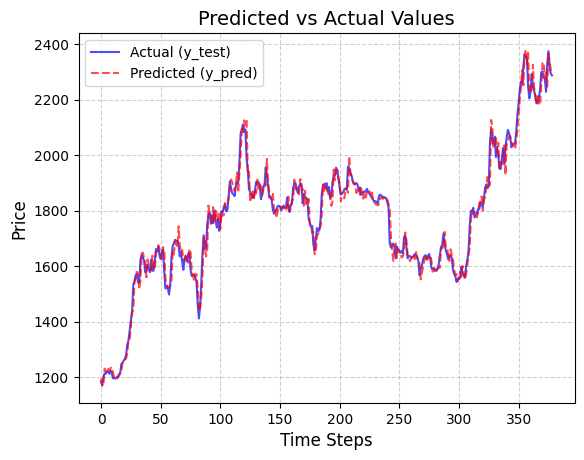

                            Coefficients
open                          243.534622
high                         -347.069221
low                          -147.915048
close                        1188.748585
volume                        -57.635465
base_asset_volume             130.283114
no_trades                      -2.763168
taker_buy_vol                  55.487433
taker_buy_base_asset_vol     -108.954000
open_1                       -112.808282
high_1                        149.149146
low_1                         -31.223954
close_1                       -91.867524
volume_1                      -34.539348
base_asset_volume_1            -7.245169
no_trades_1                    43.494564
taker_buy_vol_1                32.583662
taker_buy_base_asset_vol_1    -51.901580
open_2                       -139.536119
high_2                        -16.967857
low_2                         116.242494
close_2                        37.761771
volume_2                      -37.319768
base_asset_volum

In [6]:
model = LinearRegression()
model.fit(X_train, y_train)

y_pred = model.predict(X_test)
print(r2_score(y_test, y_pred))
print(mean_absolute_error(y_test, y_pred))

plt.plot(y_test.values, label="Actual (y_test)", color='blue', linestyle='-', alpha=0.7)

# Plot predicted values (y_pred)
plt.plot(y_pred, label="Predicted (y_pred)", color='red', linestyle='--', alpha=0.7)

# Add titles and labels
plt.title("Predicted vs Actual Values", fontsize=14)
plt.xlabel("Time Steps", fontsize=12)
plt.ylabel("Price", fontsize=12)
plt.legend()
plt.grid(True, linestyle='--', alpha=0.6)

# Show the plot
plt.show()

cdf = pd.DataFrame(model.coef_, df.loc[:, df.columns != 'next_price'].columns, columns=['Coefficients'])
print(cdf)

In [7]:
cv = RepeatedKFold(n_splits=10, n_repeats=3)
model = LassoCV(alphas=np.arange(0,1,0.01), cv=cv, n_jobs=-1)
model.fit(X_train, y_train)

print(f'{model.alpha_}')
print(model.coef_)

/home/txuglassop/.local/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:683: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 177598.00260748528, tolerance: 167254.42720602322
  model = cd_fast.enet_coordinate_descent_gram(
/home/txuglassop/.local/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:683: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 188345.85218168423, tolerance: 167627.4680267756
  model = cd_fast.enet_coordinate_descent_gram(
/home/txuglassop/.local/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:683: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 175618.01916358434, tolerance: 164915.34448804666
  model = cd_fast.enet_coordinate_descent_gram(
/home/txuglassop/.local/lib/python3.10/site-packages/sklear

0.45
[ 2.53382640e+02  3.20424232e+02  1.36730152e+02  8.45513740e+02
 -0.00000000e+00  6.62414285e+00  2.10732227e+00 -0.00000000e+00
  0.00000000e+00  4.37246976e+01 -2.70549160e+00 -8.56539471e+01
 -3.53662226e+02  0.00000000e+00 -1.20344419e+01  1.46468427e+01
  0.00000000e+00 -1.81212363e+01 -1.11836732e+01 -1.19348496e+00
 -0.00000000e+00 -1.20073821e-02  6.91525941e-02 -1.28419002e+01
 -0.00000000e+00  3.23684674e+00 -4.79760554e-02 -2.87425916e+01
 -0.00000000e+00 -0.00000000e+00 -0.00000000e+00 -5.87391529e+00
 -0.00000000e+00  1.06898348e+01 -0.00000000e+00 -0.00000000e+00
  0.00000000e+00  0.00000000e+00 -0.00000000e+00 -0.00000000e+00
 -2.85817506e+00  0.00000000e+00  0.00000000e+00 -0.00000000e+00
  1.86943465e+01 -0.00000000e+00  0.00000000e+00  0.00000000e+00
  2.30627458e+00  0.00000000e+00 -1.34830138e+01  0.00000000e+00
  2.20136603e+00 -0.00000000e+00 -8.26672577e+00]


/home/txuglassop/.local/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:683: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3123006.8765337467, tolerance: 168074.89093320598
  model = cd_fast.enet_coordinate_descent_gram(
/home/txuglassop/.local/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:683: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 188623.77952311002, tolerance: 166249.8489894458
  model = cd_fast.enet_coordinate_descent_gram(
/home/txuglassop/.local/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:683: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 188301.21551875956, tolerance: 167513.7293802277
  model = cd_fast.enet_coordinate_descent_gram(
/home/txuglassop/.local/lib/python3.10/site-packages/sklearn

In [8]:
y_pred = model.predict(X_test)
print(r2_score(y_test, y_pred))
print(mean_absolute_error(y_test, y_pred))

0.9805640761302828
24.390142625940385


adding some features...

In [13]:
df = df_raw

# custom features from feature_engineering.py
df = add_atr(df)
df = add_ema(df)
df = add_vwap(df)
df = add_dow(df)
df = pd.get_dummies(df, columns=['day_of_week'], prefix='dow', drop_first=True)

# lag features to capture non-stationary nature
lag_factor = 5
cols = ['open', 'high', 'low', 'close', 'volume', 'base_asset_volume', 'no_trades', 'taker_buy_vol', 'taker_buy_base_asset_vol']

for lag in range(1, lag_factor+1):
    for col in cols:
        newcol = np.zeros(df.shape[0]) * np.nan
        newcol[lag:] = df[col].values[:-lag]
        df.insert(len(df.columns), "{0}_{1}".format(col, lag), newcol)

df['avg_price'] = (df['high'] + df['low'] + df['close']) / 3
df['next_price'] = df['avg_price'].shift(-1)

df = df.dropna()

df.head()

,date,open,high,low,close,volume,base_asset_volume,no_trades,taker_buy_vol,taker_buy_base_asset_vol,...,high_5,low_5,close_5,volume_5,base_asset_volume_5,no_trades_5,taker_buy_vol_5,taker_buy_base_asset_vol_5,avg_price,next_price
14,2020-01-15,165.60,171.98,159.20,166.40,721687.8038,1.192399e+08,251183,350727.9639,57992191.98,...,145.17,135.32,144.84,4.094036e+05,5.737753e+07,167313.0,212395.40490,29753335.79,165.860000,163.136667
15,2020-01-16,166.40,167.40,157.80,164.21,456170.8672,7.403865e+07,179108,221669.3963,35985561.13,...,148.05,142.09,142.38,3.683506e+05,5.314936e+07,156488.0,189781.12130,27384707.93,163.136667,168.933333
16,2020-01-17,164.24,174.81,162.14,169.85,767180.6785,1.299093e+08,273867,375143.0151,63553850.73,...,146.60,141.76,146.54,2.295419e+05,3.311285e+07,110842.0,112369.46850,16214587.13,168.933333,172.853333
17,2020-01-18,169.92,179.50,164.92,174.14,688783.1798,1.193883e+08,240660,350447.0151,60783310.67,...,147.00,142.27,143.58,2.079966e+05,2.988810e+07,102544.0,99446.20096,14292973.20,172.853333,168.833333
18,2020-01-19,174.10,178.05,161.66,166.79,624681.2860,1.056914e+08,203953,307350.6395,51957534.85,...,171.70,143.51,165.64,1.108476e+06,1.734920e+08,321408.0,569410.84450,89171070.40,168.833333,165.813333


In [15]:
X = df.loc[:, ~df.columns.isin(['next_price', 'date'])]
y = df['next_price']

scaler = StandardScaler()
X = scaler.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, shuffle=False)

In [17]:
cv = RepeatedKFold(n_splits=10, n_repeats=3)
model = LassoCV(alphas=np.arange(0,1,0.01), cv=cv, n_jobs=-1, max_iter=10_000)
model.fit(X_train, y_train)

print(f'{model.alpha_}')
print(model.coef_)

/home/txuglassop/.local/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:683: UserWarning: Coordinate descent without L1 regularization may lead to unexpected results and is discouraged. Set l1_ratio > 0 to add L1 regularization.
  model = cd_fast.enet_coordinate_descent_gram(
/home/txuglassop/.local/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:683: UserWarning: Coordinate descent without L1 regularization may lead to unexpected results and is discouraged. Set l1_ratio > 0 to add L1 regularization.
  model = cd_fast.enet_coordinate_descent_gram(
/home/txuglassop/.local/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:683: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2751519.8078415394, tolerance: 166201.6467302752
  model = cd_fast.enet_coordinate_descent_gram(
/home/txuglassop/.local/lib/python3.10/site-packages/sklearn/linear_model/_coordina

0.98
[ 1.64818830e+01  0.00000000e+00  0.00000000e+00  1.07573344e+03
 -0.00000000e+00  0.00000000e+00  8.75318182e+00 -0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00 -0.00000000e+00 -1.62716218e+00
  0.00000000e+00 -0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  1.06510231e+01 -0.00000000e+00 -8.92977926e+00
  0.00000000e+00 -0.00000000e+00 -0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00 -0.00000000e+00
 -8.51276701e+00 -0.00000000e+00 -0.00000000e+00 -0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
 -2.14030457e+00  0.00000000e+00  5.37348922e+00 -0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00 -0.00000000e+00  0.00000000e+00  8.30807904e+00
 -9.27649648e-01  6.43271202e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00 -0.00000000e+00 -9.26835961e+00
 -0.00000000e+00 -0.

/home/txuglassop/.local/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:683: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3008273.6777563095, tolerance: 163484.75409697313
  model = cd_fast.enet_coordinate_descent_gram(


In [18]:
y_pred = model.predict(X_test)

print(r2_score(y_test, y_pred))
print(mean_absolute_error(y_test, y_pred))

0.980976718319495
23.60779916212932
